In [1]:
import os, glob
import pandas
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
import findspark
findspark.init()
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

## Load data

In [3]:
raw_data = spark.read.csv("data/green_taxi/*.csv", header= True, inferSchema=True)

In [4]:
raw_data.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- lpep_pickup_datetime: timestamp (nullable = true)
 |-- lpep_dropoff_datetime: timestamp (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- ehail_fee: string (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- trip_type: integer (nullable = true)



add trip_duration column and trip_speed column

In [4]:
# add trip_duration column
timeFmt = "MM-dd-yyyy'T'HH:mm:ss"
time_diff = (F.unix_timestamp('lpep_dropoff_datetime', format=timeFmt) - F.unix_timestamp('lpep_pickup_datetime', format=timeFmt)) / 3600
raw_data = raw_data.withColumn("trip_duration", time_diff)

# add trip_speed column
raw_data = raw_data.withColumn("trip_speed", raw_data.trip_distance / raw_data.trip_duration)

get first 1 milion samples for some statistical computations

In [6]:
tmp = raw_data.limit(1000000).select('trip_distance', 'fare_amount', 'tip_amount', 'tolls_amount', 'total_amount', 'trip_duration', 'trip_speed').toPandas()

In [7]:
tmp

,trip_distance,fare_amount,tip_amount,tolls_amount,total_amount,trip_duration,trip_speed
0,7.14,28.0,5.76,0.00,34.56,0.626389,11.398670
1,2.17,9.0,0.00,0.00,10.30,0.150833,14.386740
2,1.70,8.0,1.86,0.00,11.16,23.998889,0.070837
3,3.47,13.0,4.29,0.00,18.59,0.211111,16.436842
4,1.89,8.5,1.96,0.00,11.76,0.136944,13.801217
5,3.40,15.0,0.00,0.00,16.30,0.316111,10.755712
6,0.91,5.5,0.00,0.00,6.80,0.077500,11.741935
7,14.57,58.5,8.00,0.00,67.80,0.000000,NaN
8,9.90,47.0,16.15,5.54,69.99,0.000000,NaN
9,2.12,10.0,0.00,0.00,11.30,0.185000,11.459459


plot histogram

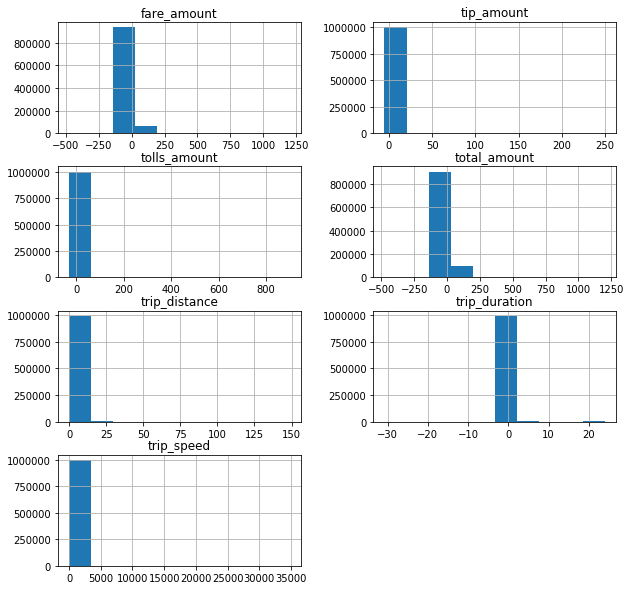

In [8]:
hist = tmp.hist(bins=10, figsize=(10,10), layout=(4,2))

In [9]:
# some statistics of continuous-value features
tmp['trip_speed'].describe(percentiles=[0.0001, 0.001, 0.1, 0.5, 0.9, 0.999, 0.9999])

count     999281.000000
mean          15.552213
std          138.723653
min           -0.077989
0.01%          0.000000
0.1%           0.000000
10%            7.270742
50%           11.756168
90%           19.880843
99.9%        499.745455
99.99%      5726.592000
max        34800.000000
Name: trip_speed, dtype: float64

group to detect invalid values for disrete-value features 

discrete-value features: VendorID, passenger_count, extra, improvement_surcharge, payment_type, RatecodeID, trip_type

In [5]:
raw_data.createOrReplaceTempView("green_taxi_table")

In [43]:
spark.sql("SELECT passenger_count, count(*) \
            FROM green_taxi_table\
            GROUP BY passenger_count").show()

+---------------+--------+
|passenger_count|count(1)|
+---------------+--------+
|              1| 1120759|
|              6|   20886|
|              3|   30335|
|              5|   46479|
|              9|      10|
|              4|    9618|
|              8|      28|
|              7|      30|
|              2|  104131|
|              0|     234|
+---------------+--------+



# clean the data

filter dataset by criterions, see the paper for descriptions

In [5]:
cleaned_data = raw_data.filter((raw_data.trip_distance >= 0.1) & (raw_data.fare_amount >= 2.5) &
                          (raw_data.tip_amount >= 0) & (raw_data.tolls_amount >= 0) & (raw_data.tolls_amount <= 20)
                          & (raw_data.extra.isin([0, 0.5, 1.0]) & (raw_data.improvement_surcharge.isin([0, 0.3])) &
                           (raw_data.total_amount > 0) & (raw_data.total_amount <= 300) 
                           & (raw_data.trip_duration > 0) & (raw_data.trip_duration <= 5)
                            & (raw_data.trip_speed > 0) & (raw_data.trip_speed <= 60) ))

In [28]:
cleaned_data.count()

23171632

In [12]:
cleaned_data.select(['fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount']).show()

+-----------+-----+-------+----------+------------+---------------------+------------+
|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|
+-----------+-----+-------+----------+------------+---------------------+------------+
|       28.0|  0.0|    0.5|      5.76|         0.0|                  0.3|       34.56|
|        9.0|  0.5|    0.5|       0.0|         0.0|                  0.3|        10.3|
|       13.0|  0.5|    0.5|      4.29|         0.0|                  0.3|       18.59|
|        8.5|  0.5|    0.5|      1.96|         0.0|                  0.3|       11.76|
|       15.0|  0.5|    0.5|       0.0|         0.0|                  0.3|        16.3|
|        5.5|  0.5|    0.5|       0.0|         0.0|                  0.3|         6.8|
|       10.0|  0.5|    0.5|       0.0|         0.0|                  0.3|        11.3|
|       10.0|  0.5|    0.5|       0.0|         0.0|                  0.3|        11.3|
|        7.0|  0.0|    0.5|      1.95|     

add some columns indicating time of trips

In [6]:
cleaned_data = cleaned_data.withColumn("day_in_week", F.dayofweek(cleaned_data.lpep_pickup_datetime))
cleaned_data = cleaned_data.withColumn("trip_hour", F.hour(cleaned_data.lpep_pickup_datetime))
cleaned_data = cleaned_data.withColumn("trip_month", F.concat(F.year(cleaned_data.lpep_pickup_datetime), F.month(cleaned_data.lpep_pickup_datetime)))
#cleaned_data = cleaned_data.withColumn("trip_year", F.year(cleaned_data.lpep_pickup_datetime))
cleaned_data = cleaned_data.withColumn("all_tax", cleaned_data.extra + cleaned_data.mta_tax + cleaned_data.tolls_amount)

In [37]:
cleaned_data.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- lpep_pickup_datetime: timestamp (nullable = true)
 |-- lpep_dropoff_datetime: timestamp (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- ehail_fee: string (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- trip_type: integer (nullable = true)
 |-- trip_duration: double (nullable = true)
 |-- trip_speed: double (nullable = true)
 |-- day_in_week: integer (nullable = true)
 |-- t

# Trip clustering

### Use K-means

In [ ]:
# reference: https://medium.com/tensorist/using-k-means-to-analyse-hacking-attacks-81957c492c93

In [11]:
from pyspark.ml.feature import StandardScaler
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.clustering import GaussianMixture

Feature engineering: select columns and normalize values

In [8]:
cols = ['passenger_count', 'trip_distance', 'trip_duration', 'trip_speed', 'tip_amount', 'total_amount']

assembler = VectorAssembler(inputCols=cols, outputCol='features')
assembled_data = assembler.transform(cleaned_data)

scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures')
scaler_model = scaler.fit(assembled_data)
scaled_data = scaler_model.transform(assembled_data)

Cluster evaluation: calculate silhouette score

In [9]:
evaluator = ClusteringEvaluator()

Run K-means for k = 2, 3, 4

In [66]:
for k in range(2, 5):
    print("k = {}:".format(k))
    k_means = KMeans(featuresCol='scaledFeatures', k=k)
    model = k_means.fit(scaled_data)
    
    predictions = model.transform(scaled_data)
    silhouette_score = evaluator.evaluate(predictions)
    print("\tsilhouette score: {}".format(silhouette_score))
    
    centroids = [centroid * scaler_model.std + scaler_model.mean for centroid in model.clusterCenters()]
    
    print("\tcentroids: {}".format(centroids))
    
    predictions.groupBy('prediction').count().show()
    
    print("\n____________________________________________\n")

k = 2:
	silhouette score: 0.781112892756308
	centroids: [array([ 2.72195855,  4.64046256,  0.39012064, 23.63708739,  1.90421452,
       25.57399121]), array([ 2.73983984, 10.71040078,  0.72329429, 30.0155829 ,  4.31156104,
       47.37547947])]
+----------+--------+
|prediction|   count|
+----------+--------+
|         1| 3769868|
|         0|19401764|
+----------+--------+


____________________________________________

k = 3:
	silhouette score: 0.6632259909707625
	centroids: [array([ 2.7175162 ,  4.28961133,  0.3663909 , 23.14589651,  1.77122225,
       24.27495377]), array([ 2.74061951, 14.64667883,  0.9211745 , 31.80582099,  6.24902617,
       61.96628543]), array([ 2.74342597,  7.77177353,  0.57885747, 27.7605177 ,  3.05235985,
       36.84473848])]
+----------+--------+
|prediction|   count|
+----------+--------+
|         1| 1126599|
|         2| 5589905|
|         0|16455128|
+----------+--------+


____________________________________________

k = 4:
	silhouette score: 0.48561

Try GMM model, this algorithm takes alot of time

In [13]:
gmm = GaussianMixture().setK(2)
gmm_model = gmm.fit(scaled_data)
predictions = model.transform(scaled_data)
silhouette_score = evaluator.evaluate(predictions)

# trip exploration

In [7]:
cleaned_data.createOrReplaceTempView("green_taxi_table")

#### Identify top 5 longest trips

In [14]:
selected_attributes = "lpep_pickup_datetime, PULocationID, DOLocationID, trip_distance, trip_duration, trip_speed, fare_amount, tip_amount, total_amount"

In [15]:
selected_attributes = "lpep_pickup_datetime, PULocationID, DOLocationID, trip_distance, total_amount"
spark.sql("SELECT {} \
            FROM green_taxi_table \
            ORDER BY trip_distance DESC \
            LIMIT 5".format(selected_attributes)).show()

+--------------------+------------+------------+-------------+------------------+------------------+-----------+----------+------------+
|lpep_pickup_datetime|PULocationID|DOLocationID|trip_distance|     trip_duration|        trip_speed|fare_amount|tip_amount|total_amount|
+--------------------+------------+------------+-------------+------------------+------------------+-----------+----------+------------+
| 2017-05-02 16:07:02|         205|          23|       128.81|3.2977777777777777|39.059636118598384|       70.0|       0.0|        70.0|
| 2017-06-19 14:24:13|         242|          23|       126.98| 3.924722222222222| 32.35388208648879|       90.0|       0.0|        90.0|
| 2016-08-22 13:29:34|          92|          23|       122.82|3.3158333333333334| 37.04046242774566|      100.0|       0.0|       100.0|
| 2016-08-24 16:59:14|         197|          19|       114.17| 4.051388888888889|28.180459376071305|      200.0|       0.0|       200.0|
| 2018-06-24 16:44:32|         130|      

#### Identify top 5 shortest trips

In [34]:
spark.sql("SELECT {} \
            FROM green_taxi_table \
            ORDER BY trip_distance ASC \
            LIMIT 5".format(selected_attributes)).show()

+--------------------+------------+------------+-------------+--------------------+------------------+-----------+----------+------------+
|lpep_pickup_datetime|PULocationID|DOLocationID|trip_distance|       trip_duration|        trip_speed|fare_amount|tip_amount|total_amount|
+--------------------+------------+------------+-------------+--------------------+------------------+-----------+----------+------------+
| 2016-07-01 06:31:33|          80|         112|          0.1|0.036944444444444446| 2.706766917293233|        3.5|       0.0|         4.3|
| 2016-07-01 08:55:49|          97|          97|          0.1|0.014722222222222222|6.7924528301886795|        2.5|       0.0|         3.3|
| 2016-07-01 06:24:26|         243|         243|          0.1|0.002777777777777778|              36.0|        2.5|       0.0|         3.3|
| 2016-07-01 02:28:45|         179|         179|          0.1|                0.02|               5.0|        3.0|       0.0|         4.3|
| 2016-07-01 07:53:48|     

#### Identify top 5 highest paid trips

In [21]:
spark.sql("SELECT {} \
            FROM green_taxi_table \
            ORDER BY total_amount DESC \
            LIMIT 5".format(selected_attributes)).show()

+--------------------+------------+------------+-------------+--------------------+------------------+-----------+----------+------------+
|lpep_pickup_datetime|PULocationID|DOLocationID|trip_distance|       trip_duration|        trip_speed|fare_amount|tip_amount|total_amount|
+--------------------+------------+------------+-------------+--------------------+------------------+-----------+----------+------------+
| 2016-07-11 19:40:13|         225|          61|         0.86|  0.8022222222222222|  1.07202216066482|      250.0|      50.0|       300.0|
| 2016-07-09 15:52:21|          37|          37|         0.12| 0.03111111111111111| 3.857142857142857|      300.0|       0.0|       300.0|
| 2016-07-10 12:14:40|          89|          89|         0.55| 0.14194444444444446|3.8747553816046967|      300.0|       0.0|       300.0|
| 2016-07-11 10:00:52|          85|          85|         0.44|0.036944444444444446|11.909774436090226|      300.0|       0.0|       300.0|
| 2016-07-23 18:58:05|     

#### Identify top 5 lowest paid trips

In [35]:
spark.sql("SELECT {} \
            FROM green_taxi_table \
            ORDER BY total_amount ASC \
            LIMIT 5".format(selected_attributes)).show()

+--------------------+------------+------------+-------------+--------------------+------------------+-----------+----------+------------+
|lpep_pickup_datetime|PULocationID|DOLocationID|trip_distance|       trip_duration|        trip_speed|fare_amount|tip_amount|total_amount|
+--------------------+------------+------------+-------------+--------------------+------------------+-----------+----------+------------+
| 2016-07-17 16:34:18|         152|         235|        12.55|   1.251111111111111|10.031083481349912|        2.5|       0.0|         2.5|
| 2016-07-30 14:58:47|          28|          28|          0.1|0.007222222222222222|13.846153846153847|        2.5|       0.0|         2.5|
| 2016-07-09 12:58:16|         166|         151|         1.03| 0.08305555555555555|12.401337792642142|        2.5|       0.0|         2.5|
| 2016-07-26 14:48:01|          74|         247|         6.84|              0.5525|12.380090497737557|        2.5|       0.0|         2.5|
| 2016-07-30 12:17:30|     

#### Identify top 5 fastest trips

In [32]:
spark.sql("SELECT {} \
            FROM green_taxi_table \
            ORDER BY trip_speed DESC \
            LIMIT 5".format(selected_attributes)).show()

+--------------------+------------+------------+-------------+--------------------+----------+-----------+----------+------------+
|lpep_pickup_datetime|PULocationID|DOLocationID|trip_distance|       trip_duration|trip_speed|fare_amount|tip_amount|total_amount|
+--------------------+------------+------------+-------------+--------------------+----------+-----------+----------+------------+
| 2016-07-09 21:56:13|         152|         152|          0.4|0.006666666666666667|      60.0|        2.5|       0.0|         3.8|
| 2016-07-15 23:22:47|          17|          17|          0.5|0.008333333333333333|      60.0|        2.5|       0.0|         3.8|
| 2016-07-13 22:34:43|          91|          91|          0.1|0.001666666666666...|      60.0|        2.5|       3.2|         7.0|
| 2016-07-02 07:59:46|          28|          28|          0.1|0.001666666666666...|      60.0|       25.8|       0.0|        25.8|
| 2016-07-15 16:48:31|         258|         258|          1.7|0.028333333333333332|

#### Identify top 5 slowest trips

In [31]:
spark.sql("SELECT {} \
            FROM green_taxi_table \
            ORDER BY trip_speed ASC \
            LIMIT 5".format(selected_attributes)).show()

+--------------------+------------+------------+-------------+------------------+--------------------+-----------+----------+------------+
|lpep_pickup_datetime|PULocationID|DOLocationID|trip_distance|     trip_duration|          trip_speed|fare_amount|tip_amount|total_amount|
+--------------------+------------+------------+-------------+------------------+--------------------+-----------+----------+------------+
| 2016-09-07 19:25:57|         116|         116|          0.1|            4.5675|0.021893814997263276|        7.0|       0.0|         7.0|
| 2017-02-24 19:09:56|         254|         254|         0.11| 4.834444444444444|0.022753390025281546|       23.0|       0.0|        23.0|
| 2017-12-14 20:34:32|         182|         212|          0.1|3.4244444444444446|0.029201817001946788|       15.0|       0.0|        15.0|
| 2016-07-29 19:39:49|          74|          74|         0.13| 4.336388888888889| 0.02997886105950932|        3.0|       0.0|         4.8|
| 2017-09-06 19:24:52|     

#### Identify top 5 trips with highest tip amount

In [33]:
spark.sql("SELECT {} \
            FROM green_taxi_table \
            ORDER BY tip_amount DESC \
            LIMIT 5".format(selected_attributes)).show()

+--------------------+------------+------------+-------------+-------------------+-----------------+-----------+----------+------------+
|lpep_pickup_datetime|PULocationID|DOLocationID|trip_distance|      trip_duration|       trip_speed|fare_amount|tip_amount|total_amount|
+--------------------+------------+------------+-------------+-------------------+-----------------+-----------+----------+------------+
| 2018-01-22 04:36:27|         129|          82|         1.25|0.15055555555555555|8.302583025830259|        7.5|    252.22|      261.02|
| 2016-07-29 19:20:32|          28|          28|          0.7|0.14083333333333334|4.970414201183432|        6.5|     250.8|       259.1|
| 2016-08-03 10:53:35|         130|         122|         1.67| 0.9672222222222222|1.726593911545089|       29.5|     250.7|       281.0|
| 2017-03-24 20:05:19|          71|          72|         3.93| 0.9305555555555556|4.223283582089552|       34.0|     250.0|       285.3|
| 2016-12-02 15:00:08|         122|      

# Location exploration

#### Load location information

In [218]:
location_info = spark.read.csv("data/taxi_zone_lookup.csv", header=True, inferSchema=True)
location_info.show()
location_info.createOrReplaceTempView("location_table")

+----------+-------------+--------------------+------------+
|LocationID|      Borough|                Zone|service_zone|
+----------+-------------+--------------------+------------+
|         1|          EWR|      Newark Airport|         EWR|
|         2|       Queens|         Jamaica Bay|   Boro Zone|
|         3|        Bronx|Allerton/Pelham G...|   Boro Zone|
|         4|    Manhattan|       Alphabet City| Yellow Zone|
|         5|Staten Island|       Arden Heights|   Boro Zone|
|         6|Staten Island|Arrochar/Fort Wad...|   Boro Zone|
|         7|       Queens|             Astoria|   Boro Zone|
|         8|       Queens|        Astoria Park|   Boro Zone|
|         9|       Queens|          Auburndale|   Boro Zone|
|        10|       Queens|        Baisley Park|   Boro Zone|
|        11|     Brooklyn|          Bath Beach|   Boro Zone|
|        12|    Manhattan|        Battery Park| Yellow Zone|
|        13|    Manhattan|   Battery Park City| Yellow Zone|
|        14|     Brookly

#### Create dataframes for fast location queries 

In [34]:
pickups_data = spark.sql("SELECT PULocationID, Borough, Zone, service_zone, AVG(trip_distance) as avg_trip_distance, \
                            AVG(fare_amount) as avg_fare_amount,\
                            AVG(total_amount) as avg_total_amount, \
                            AVG(tip_amount) as avg_trip_amount, \
                            AVG(trip_speed) as avg_trip_speed, \
                            AVG(trip_duration) as avg_trip_duration \
                            FROM green_taxi_table, location_table \
                            WHERE PULocationID == LocationID \
                            GROUP BY PULocationID, Borough, Zone, service_zone")
pickups_data.createOrReplaceTempView("pickups_table")

In [46]:
dropoffs_data = spark.sql("SELECT DOLocationID, Borough, Zone, service_zone, AVG(trip_distance) as avg_trip_distance, \
                            AVG(fare_amount) as avg_fare_amount,\
                            AVG(total_amount) as avg_total_amount, \
                            AVG(tip_amount) as avg_trip_amount, \
                            AVG(trip_speed) as avg_trip_speed, \
                            AVG(trip_duration) as avg_trip_duration \
                            FROM green_taxi_table, location_table \
                            WHERE DOLocationID == LocationID \
                            GROUP BY DOLocationID, Borough, Zone, service_zone")
dropoffs_data.createOrReplaceTempView("dropoffs_table")

#### Identify top 5 location with the most pickups

In [50]:
spark.sql("SELECT PULocationID, Borough, Zone, service_zone, count(*) as num_trips \
            FROM green_taxi_table, location_table \
            WHERE PULocationID == LocationID \
            GROUP BY PULocationID, Borough, Zone, service_zone \
            ORDER BY num_trips DESC \
            LIMIT 5").show()

+------------+---------+-----------------+------------+---------+
|PULocationID|  Borough|             Zone|service_zone|num_trips|
+------------+---------+-----------------+------------+---------+
|          74|Manhattan|East Harlem North|   Boro Zone|  1401230|
|          41|Manhattan|   Central Harlem|   Boro Zone|  1306566|
|          75|Manhattan|East Harlem South|   Boro Zone|  1223346|
|           7|   Queens|          Astoria|   Boro Zone|  1161720|
|          82|   Queens|         Elmhurst|   Boro Zone|  1003063|
+------------+---------+-----------------+------------+---------+



#### Identify top 5 location with the least pickups

In [52]:
spark.sql("SELECT PULocationID, Borough, Zone, service_zone, count(*) as num_trips \
            FROM green_taxi_table, location_table \
            WHERE PULocationID == LocationID \
            GROUP BY PULocationID, Borough, Zone, service_zone \
            ORDER BY num_trips ASC \
            LIMIT 5").show()

+------------+-------------+-----------------+------------+---------+
|PULocationID|      Borough|             Zone|service_zone|num_trips|
+------------+-------------+-----------------+------------+---------+
|         110|Staten Island| Great Kills Park|   Boro Zone|        1|
|          12|    Manhattan|     Battery Park| Yellow Zone|        1|
|          99|Staten Island|  Freshkills Park|   Boro Zone|        6|
|         204|Staten Island|Rossville/Woodrow|   Boro Zone|        8|
|           2|       Queens|      Jamaica Bay|   Boro Zone|        9|
+------------+-------------+-----------------+------------+---------+



#### Identify top 5 location with the most drop-offs

In [51]:
spark.sql("SELECT DOLocationID, Borough, Zone, service_zone, count(*) as num_trips \
            FROM green_taxi_table, location_table \
            WHERE DOLocationID == LocationID \
            GROUP BY DOLocationID, Borough, Zone, service_zone \
            ORDER BY num_trips DESC \
            LIMIT 5").show()

+------------+---------+--------------------+------------+---------+
|DOLocationID|  Borough|                Zone|service_zone|num_trips|
+------------+---------+--------------------+------------+---------+
|          74|Manhattan|   East Harlem North|   Boro Zone|   771911|
|          42|Manhattan|Central Harlem North|   Boro Zone|   764769|
|           7|   Queens|             Astoria|   Boro Zone|   721274|
|          41|Manhattan|      Central Harlem|   Boro Zone|   685612|
|         129|   Queens|     Jackson Heights|   Boro Zone|   641134|
+------------+---------+--------------------+------------+---------+



#### Identify top 5 location with the least drop-offs

In [53]:
spark.sql("SELECT DOLocationID, Borough, Zone, service_zone, count(*) as num_trips \
            FROM green_taxi_table, location_table \
            WHERE DOLocationID == LocationID \
            GROUP BY DOLocationID, Borough, Zone, service_zone \
            ORDER BY num_trips ASC \
            LIMIT 5").show()

+------------+-------------+--------------------+------------+---------+
|DOLocationID|      Borough|                Zone|service_zone|num_trips|
+------------+-------------+--------------------+------------+---------+
|         110|Staten Island|    Great Kills Park|   Boro Zone|        1|
|         105|    Manhattan|Governor's Island...| Yellow Zone|        2|
|          99|Staten Island|     Freshkills Park|   Boro Zone|       15|
|           2|       Queens|         Jamaica Bay|   Boro Zone|       38|
|         204|Staten Island|   Rossville/Woodrow|   Boro Zone|       74|
+------------+-------------+--------------------+------------+---------+



#### highest tip by locations

In [54]:
spark.sql("SELECT PULocationID, Borough, Zone, service_zone, AVG(tip_amount) as avg_tip_amount \
            FROM green_taxi_table, location_table \
            WHERE PULocationID == LocationID \
            GROUP BY PULocationID, Borough, Zone, service_zone \
            ORDER BY avg_tip_amount DESC \
            LIMIT 5").show()

+------------+-------------+--------------------+------------+-----------------+
|PULocationID|      Borough|                Zone|service_zone|  avg_trip_amount|
+------------+-------------+--------------------+------------+-----------------+
|         109|Staten Island|         Great Kills|   Boro Zone|7.233124999999999|
|          23|Staten Island|Bloomfield/Emerso...|   Boro Zone|6.816742081447964|
|           1|          EWR|      Newark Airport|         EWR|4.775555555555555|
|         204|Staten Island|   Rossville/Woodrow|   Boro Zone|            4.275|
|         115|Staten Island| Grymes Hill/Clifton|   Boro Zone|4.187861271676301|
+------------+-------------+--------------------+------------+-----------------+



#### lowest tip by locations

In [56]:
spark.sql("SELECT PULocationID, Borough, Zone, service_zone, AVG(tip_amount) as avg_tip_amount \
            FROM green_taxi_table, location_table \
            WHERE PULocationID == LocationID \
            GROUP BY PULocationID, Borough, Zone, service_zone \
            ORDER BY avg_tip_amount ASC \
            LIMIT 5").show()

+------------+-------------+--------------------+------------+-------------------+
|PULocationID|      Borough|                Zone|service_zone|     avg_tip_amount|
+------------+-------------+--------------------+------------+-------------------+
|         110|Staten Island|    Great Kills Park|   Boro Zone|                0.0|
|         187|Staten Island|       Port Richmond|   Boro Zone|0.07972222222222224|
|         248|        Bronx|West Farms/Bronx ...|   Boro Zone|0.30118043303929426|
|          94|        Bronx|       Fordham South|   Boro Zone| 0.3298117267348036|
|         173|       Queens|        North Corona|   Boro Zone| 0.3418009298171884|
+------------+-------------+--------------------+------------+-------------------+



#### top location by speed

In [62]:
spark.sql("SELECT PULocationID, Borough, Zone, service_zone, AVG(trip_speed) as avg_trip_speed \
            FROM green_taxi_table, location_table \
            WHERE PULocationID == LocationID \
            GROUP BY PULocationID, Borough, Zone, service_zone \
            ORDER BY avg_trip_speed DESC \
            LIMIT 5").show()

+------------+-------------+--------------------+------------+------------------+
|PULocationID|      Borough|                Zone|service_zone|    avg_trip_speed|
+------------+-------------+--------------------+------------+------------------+
|          99|Staten Island|     Freshkills Park|   Boro Zone|31.158026245078844|
|          44|Staten Island|Charleston/Totten...|   Boro Zone|28.713253247760985|
|         204|Staten Island|   Rossville/Woodrow|   Boro Zone|25.699989171559377|
|           1|          EWR|      Newark Airport|         EWR|24.569574798749652|
|         132|       Queens|         JFK Airport|    Airports| 24.34501236201588|
+------------+-------------+--------------------+------------+------------------+



In [63]:
spark.sql("SELECT PULocationID, Borough, Zone, service_zone, AVG(trip_speed) as avg_trip_speed \
            FROM green_taxi_table, location_table \
            WHERE PULocationID == LocationID \
            GROUP BY PULocationID, Borough, Zone, service_zone \
            ORDER BY avg_trip_speed ASC \
            LIMIT 5").show()

+------------+---------+--------------------+------------+-----------------+
|PULocationID|  Borough|                Zone|service_zone|   avg_trip_speed|
+------------+---------+--------------------+------------+-----------------+
|          12|Manhattan|        Battery Park| Yellow Zone|6.606741573033708|
|         234|Manhattan|            Union Sq| Yellow Zone|9.069952337855929|
|         186|Manhattan|Penn Station/Madi...| Yellow Zone|9.206238522262378|
|         161|Manhattan|      Midtown Center| Yellow Zone|9.294845371350764|
|         107|Manhattan|            Gramercy| Yellow Zone| 9.55930201041732|
+------------+---------+--------------------+------------+-----------------+



#### locations having highest average number of passengers

In [64]:
spark.sql("SELECT PULocationID, Borough, Zone, service_zone, AVG(passenger_count) as avg_passenger_count \
            FROM green_taxi_table, location_table \
            WHERE PULocationID == LocationID \
            GROUP BY PULocationID, Borough, Zone, service_zone \
            ORDER BY avg_passenger_count DESC \
            LIMIT 5").show()

+------------+-------------+--------------------+------------+-------------------+
|PULocationID|      Borough|                Zone|service_zone|avg_passenger_count|
+------------+-------------+--------------------+------------+-------------------+
|          12|    Manhattan|        Battery Park| Yellow Zone|                5.0|
|         187|Staten Island|       Port Richmond|   Boro Zone|  4.111111111111111|
|          44|Staten Island|Charleston/Totten...|   Boro Zone|  3.227272727272727|
|         251|Staten Island|         Westerleigh|   Boro Zone| 3.0956521739130434|
|         245|Staten Island|       West Brighton|   Boro Zone| 3.0441176470588234|
+------------+-------------+--------------------+------------+-------------------+



In [65]:
spark.sql("SELECT PULocationID, Borough, Zone, service_zone, AVG(passenger_count) as avg_passenger_count \
            FROM green_taxi_table, location_table \
            WHERE PULocationID == LocationID \
            GROUP BY PULocationID, Borough, Zone, service_zone \
            ORDER BY avg_passenger_count ASC \
            LIMIT 5").show()

+------------+-------------+----------------+------------+-------------------+
|PULocationID|      Borough|            Zone|service_zone|avg_passenger_count|
+------------+-------------+----------------+------------+-------------------+
|         110|Staten Island|Great Kills Park|   Boro Zone|                1.0|
|         176|Staten Island|         Oakwood|   Boro Zone|                1.1|
|           2|       Queens|     Jamaica Bay|   Boro Zone| 1.1111111111111112|
|          45|    Manhattan|       Chinatown| Yellow Zone|  1.146341463414634|
|         203|       Queens|        Rosedale|   Boro Zone| 1.1675884955752212|
+------------+-------------+----------------+------------+-------------------+



#### location - trip_distance

In [66]:
spark.sql("SELECT PULocationID, Borough, Zone, service_zone, AVG(trip_distance) as avg_trip_distance \
            FROM green_taxi_table, location_table \
            WHERE PULocationID == LocationID \
            GROUP BY PULocationID, Borough, Zone, service_zone \
            ORDER BY avg_trip_distance DESC \
            LIMIT 5").show()

+------------+-------------+---------------+------------+------------------+
|PULocationID|      Borough|           Zone|service_zone| avg_trip_distance|
+------------+-------------+---------------+------------+------------------+
|         117|       Queens|Hammels/Arverne|   Boro Zone| 16.67577055977885|
|          86|       Queens|   Far Rockaway|   Boro Zone|14.799605263157893|
|         201|       Queens|  Rockaway Park|   Boro Zone|14.609871794871792|
|         109|Staten Island|    Great Kills|   Boro Zone|         12.838125|
|           5|Staten Island|  Arden Heights|   Boro Zone| 11.48166666666667|
+------------+-------------+---------------+------------+------------------+



In [67]:
spark.sql("SELECT PULocationID, Borough, Zone, service_zone, AVG(trip_distance) as avg_trip_distance \
            FROM green_taxi_table, location_table \
            WHERE PULocationID == LocationID \
            GROUP BY PULocationID, Borough, Zone, service_zone \
            ORDER BY avg_trip_distance ASC \
            LIMIT 5").show()

+------------+---------+--------------------+------------+------------------+
|PULocationID|  Borough|                Zone|service_zone| avg_trip_distance|
+------------+---------+--------------------+------------+------------------+
|         237|Manhattan|Upper East Side S...| Yellow Zone|1.9596845425867508|
|         234|Manhattan|            Union Sq| Yellow Zone|1.9734241245136188|
|         142|Manhattan| Lincoln Square East| Yellow Zone|2.0770916334661353|
|          41|Manhattan|      Central Harlem|   Boro Zone|2.1115612682405627|
|         141|Manhattan|     Lenox Hill West| Yellow Zone| 2.124975369458128|
+------------+---------+--------------------+------------+------------------+



# Time-related exploration

In [16]:
cleaned_data.createOrReplaceTempView("green_taxi_table")

### Changing by day in week

In [183]:
tmp = spark.sql("SELECT day_in_week, count(*) as num_trips, AVG(passenger_count) as avg_passenger_count, AVG(tip_amount) as avg_tip_amount, AVG(trip_speed) as avg_trip_speed, AVG(trip_distance) as avg_trip_distance \
            FROM green_taxi_table \
            GROUP BY day_in_week\
            ORDER BY day_in_week ASC").toPandas()

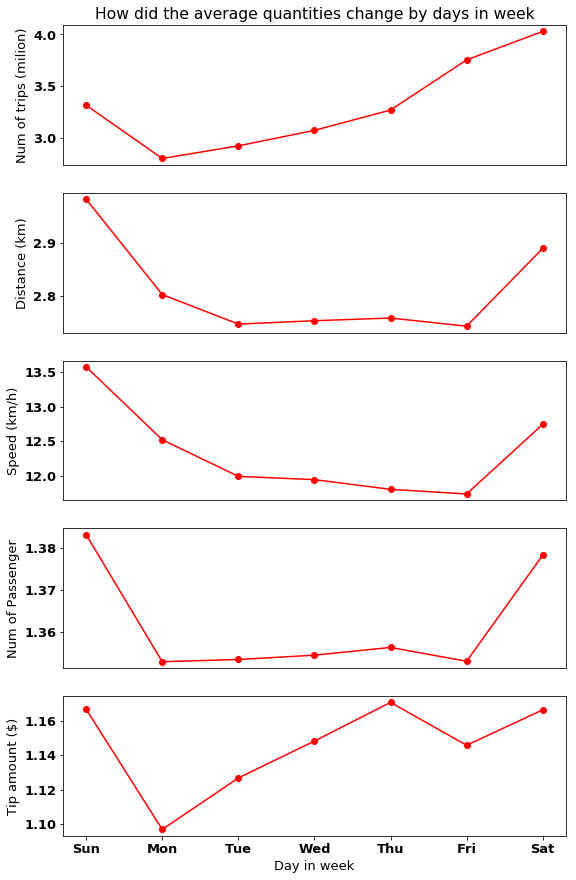

In [215]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 13}

plt.rc('font', **font)

x1 = np.arange(7)

plt.figure(figsize=(9, 18))
plt.subplot(6, 1, 1)
plt.plot(x1, tmp['num_trips'] / 1000000, 'o-', color='r')
plt.title('How did the average quantities change by days in week')
plt.xticks([])
plt.ylabel('Num of trips (milion)')

plt.subplot(6, 1, 2)
plt.plot(x1, tmp['avg_trip_distance'], 'o-', color='r')
plt.xticks([])
plt.ylabel('Distance (km)')

plt.subplot(6, 1, 3)
plt.plot(x1, tmp['avg_trip_speed'], 'o-', color='r')
plt.xticks([])
plt.ylabel('Speed (km/h)')

plt.subplot(6, 1, 4)
plt.plot(x1, tmp['avg_passenger_count'], 'o-', color='r')
plt.xticks([])
plt.ylabel('Num of Passenger')

plt.subplot(6, 1, 5)
plt.plot(x1, tmp['avg_tip_amount'], 'o-', color='r')
plt.xlabel('Day in week')
plt.xticks(np.arange(7), ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])
plt.ylabel('Tip amount ($)')

plt.show()

### Changing by hours in day

In [158]:
tmp = spark.sql("SELECT trip_hour, count(*) as num_trips, AVG(passenger_count) as avg_passenger_count, AVG(tip_amount) as avg_tip_amount, AVG(trip_speed) as avg_trip_speed, AVG(trip_distance) as avg_trip_distance, AVG(all_tax) as avg_all_tax \
            FROM green_taxi_table \
            GROUP BY trip_hour\
            ORDER BY trip_hour ASC").toPandas()
tmp

,trip_hour,num_trips,avg_passenger_count,avg_tip_amount,avg_trip_speed,avg_trip_distance,avg_all_tax
0,0,896051,1.387921,1.201613,14.366973,2.898903,1.057688
1,1,687224,1.398295,1.171431,14.716986,2.901275,1.055594
2,2,500342,1.414522,1.181423,15.125782,3.014471,1.055355
3,3,390964,1.429528,1.180354,15.643278,3.209504,1.074546
4,4,324166,1.427991,1.119114,16.335150,3.529215,1.123326
5,5,224158,1.392393,1.373080,18.126136,4.261221,1.245499
6,6,325224,1.327826,1.393934,16.579088,4.170279,0.823754
7,7,641442,1.329593,1.264261,13.039238,3.249537,0.705343
8,8,962870,1.326446,1.314411,11.764822,2.929706,0.653690
9,9,1015759,1.324326,1.252672,12.139446,2.919158,0.647790


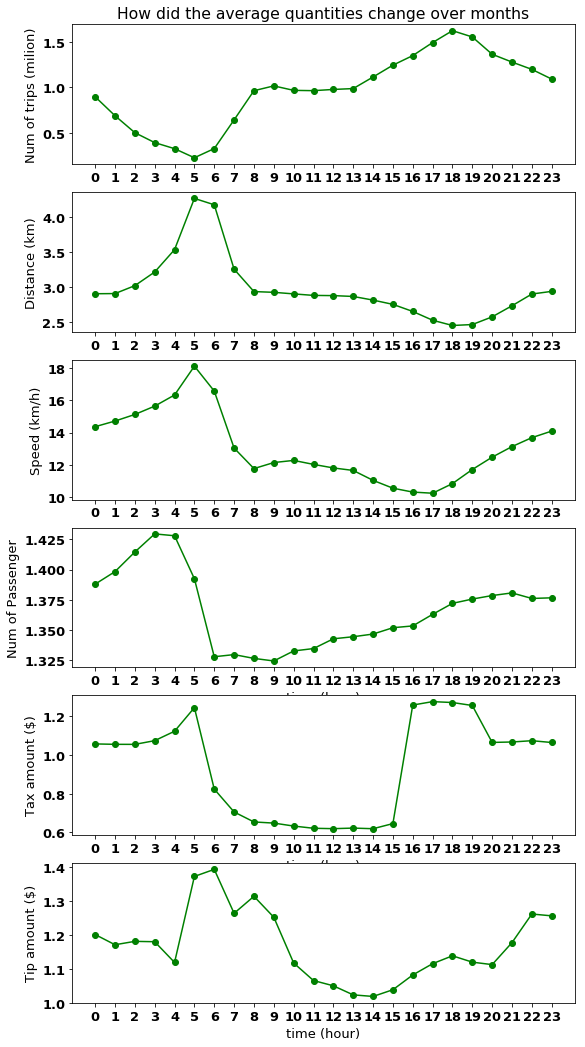

In [182]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 13}

plt.rc('font', **font)

x1 = np.arange(24)

plt.figure(figsize=(9, 18))
plt.subplot(6, 1, 1)
plt.plot(x1, tmp['num_trips'] / 1000000, 'o-', color='g')
plt.title('How did the average quantities change over months')
plt.xticks(np.arange(24))
plt.ylabel('Num of trips (milion)')

plt.subplot(6, 1, 2)
plt.plot(x1, tmp['avg_trip_distance'], 'o-', color='g')
plt.xticks(np.arange(24))
plt.ylabel('Distance (km)')

plt.subplot(6, 1, 3)
plt.plot(x1, tmp['avg_trip_speed'], 'o-', color='g')
plt.xticks(np.arange(24))
plt.ylabel('Speed (km/h)')

plt.subplot(6, 1, 4)
plt.plot(x1, tmp['avg_passenger_count'], 'o-', color='g')
plt.xlabel('time (hour)')
plt.xticks(np.arange(24))
plt.ylabel('Num of Passenger')

plt.subplot(6, 1, 5)
plt.plot(x1, tmp['avg_all_tax'], 'o-', color='g')
plt.xlabel('time (hour)')
plt.xticks(np.arange(24))
plt.ylabel('Tax amount ($)')

plt.subplot(6, 1, 6)
plt.plot(x1, tmp['avg_tip_amount'], 'o-', color='g')
plt.xlabel('time (hour)')
plt.xticks(np.arange(24))
plt.ylabel('Tip amount ($)')

plt.show()

### Chaning by months

In [17]:
tmp = spark.sql("SELECT trip_month, count(*) as num_trips, AVG(passenger_count) as avg_passenger_count, AVG(tip_amount) as avg_tip_amount, AVG(trip_speed) as avg_trip_speed, AVG(trip_distance) as avg_trip_distance, AVG(all_tax) as avg_all_tax \
            FROM green_taxi_table \
            GROUP BY trip_month\
            ORDER BY trip_month ASC").toPandas()
tmp

,trip_month,num_trips,avg_passenger_count,avg_tip_amount,avg_trip_speed,avg_trip_distance,avg_all_tax
0,200812,46,1.760870,0.164783,10.070727,2.133913,1.190435
1,20091,94,1.234043,0.605532,12.451089,5.376170,1.144894
2,20109,159,1.025157,0.797296,11.526222,3.148113,1.001761
3,20129,3,1.000000,1.153333,11.450446,1.353333,1.333333
4,201610,1216055,1.358834,1.220749,12.461245,2.808406,0.946416
5,201611,1114448,1.358435,1.178758,12.298203,2.700185,0.936215
6,201612,1188300,1.362770,1.129772,12.336054,2.651485,0.951202
7,20167,1288880,1.363696,1.270312,12.948905,2.951583,0.961527
8,20168,1207356,1.363211,1.231827,12.922211,2.943663,0.970889
9,20169,1125782,1.344308,1.222350,12.431978,2.873948,0.975544


In [98]:
from collections import defaultdict
d = defaultdict(list)
for idx, line in tmp.iterrows():
    y = line[0][:4]
    m = '0' + line[0][4:] if len(line[0]) == 5 else line[0][4:]
    if int(y) < 2016 or int(y) > 2018 or (int(y) == 2016 and int(m) < 7) or (int(y) == 2018 and int(m) >= 7):
        continue
    d["{}-{}".format(y, m)] = line[1:]

In [116]:
num_trips = []
avg_passenger_counts = []
avg_tip_amounts = []
avg_trip_speeds = []
avg_trip_distances = []
avg_all_taxs = []
for i, key in enumerate(sorted(d)):
    num_trips.append(d[key][0])
    avg_passenger_counts.append(d[key][1])
    avg_tip_amounts.append(d[key][2])
    avg_trip_speeds.append(d[key][3])
    avg_trip_distances.append(d[key][4])
    avg_all_taxs.append(d[key][5])

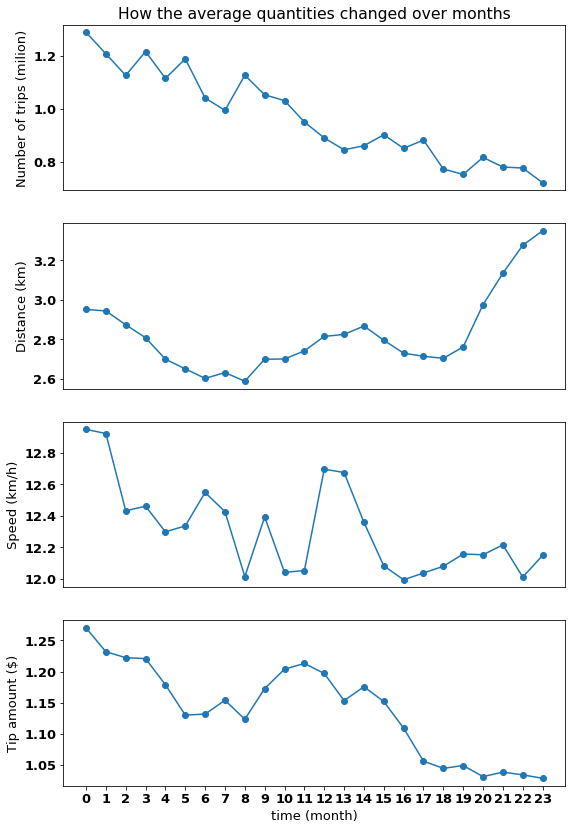

In [157]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 13}

plt.rc('font', **font)

x1 = np.arange(24)
x2 = np.linspace(0.0, 2.0)

y1 = num_trips
y2 = np.cos(2 * np.pi * x2)

plt.figure(figsize=(9, 14))
plt.subplot(4, 1, 1)
plt.plot(x1, np.array(y1) / 1000000, 'o-')
plt.title('How the average quantities changed over months')
plt.xticks([])
plt.ylabel('Number of trips (milion)')

plt.subplot(4, 1, 2)
plt.plot(x1, avg_trip_distances, 'o-')
plt.xticks([])
plt.ylabel('Distance (km)')

plt.subplot(4, 1, 3)
plt.plot(x1, avg_trip_speeds, 'o-')
plt.xticks([])
plt.ylabel('Speed (km/h)')

plt.subplot(4, 1, 4)
plt.plot(x1, avg_tip_amounts, 'o-')
plt.xlabel('time (month)')
plt.xticks(np.arange(24))
plt.ylabel('Tip amount ($)')

plt.show()

# More Visualization

trip type

In [348]:
spark.sql("SELECT trip_type, count(*) as count \
            FROM green_taxi_table\
            GROUP BY trip_type").show()

+---------+--------+
|trip_type|   count|
+---------+--------+
|        1|22910434|
|        2|  261198|
+---------+--------+



payment

In [19]:
spark.sql("SELECT payment_type, count(*) as count \
            FROM green_taxi_table\
            GROUP BY payment_type").show()

+------------+--------+
|payment_type|   count|
+------------+--------+
|           1|11892620|
|           3|   52985|
|           5|     741|
|           4|   38797|
|           2|11186489|
+------------+--------+



Pie chart presenting percentages of payment types

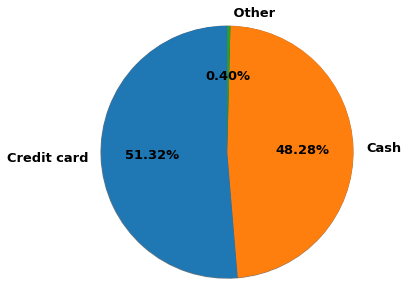

In [142]:
labels = 'Credit card', 'Cash', ' Other'
sizes = [11892620, 11186489, 52985 + 38797 + 741]
explode = (0, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')
plt.figure(figsize=(5,5))
#fig1, ax1 = plt.subplots()
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.2f%%',
        shadow=True, startangle=90, radius=9)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
#plt.title("Percentages of payment types")

plt.show()

### What is payment trend?

In [ ]:
tmp1 = spark.sql("SELECT trip_month, count(*) as num_trips\
            FROM green_taxi_table \
            WHER2 payment_type == 1 \
            GROUP BY trip_month").toPandas()
tmp2 = spark.sql("SELECT trip_month, count(*) as num_trips\
            FROM green_taxi_table \
            WHERE payment_type == 2 \
            GROUP BY trip_month").toPandas()

In [57]:
from collections import defaultdict
d = defaultdict(list)
for idx, line in tmp1.iterrows():
    y = line[0][:4]
    m = '0' + line[0][4:] if len(line[0]) == 5 else line[0][4:]
    if int(y) < 2016 or int(y) > 2018 or (int(y) == 2016 and int(m) < 7) or (int(y) == 2018 and int(m) >= 7):
        continue
    d["{}-{}".format(y, m)].append(int(line[1]))
    
for idx, line in tmp2.iterrows():
    y = line[0][:4]
    m = '0' + line[0][4:] if len(line[0]) == 5 else line[0][4:]
    if int(y) < 2016 or int(y) > 2018 or (int(y) == 2016 and int(m) < 7) or (int(y) == 2018 and int(m) >= 7):
        continue
    d["{}-{}".format(y, m)].append(int(line[1]))

In [92]:
credit_card_ratio = []
cash_ratio = []
print("month  credit_card  cash")
cnt_credit_card = 0
cnt_cash = 0
for i, key in enumerate(sorted(d)):
    print(key, d[key])
    cnt_credit_card += d[key][0]
    cnt_cash += d[key][1]
    if i % 3 == 2:
        credit_card_ratio.append(cnt_credit_card / (cnt_cash + cnt_credit_card))
        cash_ratio.append(cnt_cash / (cnt_cash + cnt_credit_card))
    cnt_credit_card = 0
    cnt_cash = 0

month  credit_card  cash
2016-07 [645458, 638161]
2016-08 [593344, 608816]
2016-09 [551409, 569695]
2016-10 [608886, 602519]
2016-11 [551292, 558823]
2016-12 [569015, 614598]
2017-01 [518886, 517061]
2017-02 [497556, 491717]
2017-03 [554848, 566898]
2017-04 [526433, 521361]
2017-05 [517688, 508620]
2017-06 [475168, 470242]
2017-07 [444547, 441004]
2017-08 [425157, 415084]
2017-09 [444303, 411797]
2017-10 [479278, 418606]
2017-11 [453444, 393249]
2017-12 [456606, 421440]
2018-01 [415166, 353704]
2018-02 [413621, 335132]
2018-03 [453579, 359154]
2018-04 [443621, 332479]
2018-05 [443660, 328480]
2018-06 [409536, 307603]


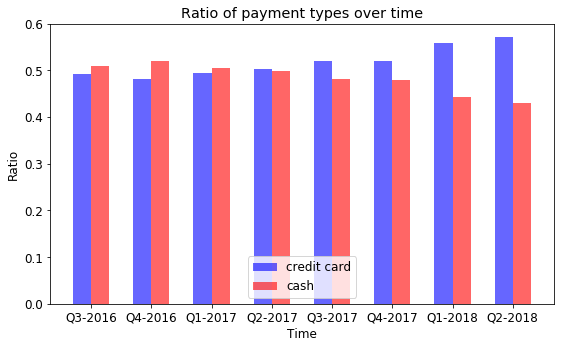

In [146]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}
plt.rc('font', **font)
n_months = 8

means_men = (20, 35, 30, 35, 27)
std_men = (2, 3, 4, 1, 2)

means_women = (25, 32, 34, 20, 25)
std_women = (3, 5, 2, 3, 3)

fig, ax = plt.subplots(figsize=(8,5))

index = np.arange(n_months)
bar_width = 0.3

opacity = 0.6

rects1 = ax.bar(index, credit_card_ratio, bar_width,
                alpha=opacity, color='b',
                label='credit card')

rects2 = ax.bar(index + bar_width, cash_ratio, bar_width,
                alpha=opacity, color='r',
                label='cash')

ax.set_xlabel('Time')
ax.set_ylabel('Ratio')
ax.set_title('Ratio of payment types over time')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(('Q3-2016', 'Q4-2016', 'Q1-2017', 'Q2-2017', 'Q3-2017', 'Q4-2017', 'Q1-2018', 'Q2-2018'))
ax.legend(loc=8, prop={'size': 12})

fig.tight_layout()
plt.show()

### Heat map vizualing flow of trips

In [228]:
tmp = spark.sql("SELECT loc1.Borough, loc2.Borough, count(*) as num_trips\
            FROM green_taxi_table, location_table AS loc1, location_table AS loc2\
            WHERE green_taxi_table.PULocationID == loc1.LocationID AND green_taxi_table.DOLocationID == loc2.LocationID  \
            GROUP BY loc1.Borough, loc2.Borough").toPandas()

In [229]:
tmp

,Borough,Borough,num_trips
0,EWR,Brooklyn,4
1,Brooklyn,Manhattan,1234334
2,EWR,Staten Island,2
3,EWR,EWR,7
4,Brooklyn,Bronx,16412
5,Brooklyn,EWR,3310
6,Manhattan,Manhattan,6539689
7,Brooklyn,Brooklyn,6465246
8,Staten Island,Brooklyn,542
9,Queens,Queens,5958775


In [240]:
Boroughes = ["EWR", "Brooklyn", "Manhattan", "Staten Island", "Queens", "Bronx"]
heat_map = [[7, 4, 5, 2, 1, 1],
           [3310, 6465246, 1234334, 3805, 408120, 16412],
           [3744, 47005, 6539689, 323, 174997, 570286],
           [18, 542, 111, 2230, 81, 15],
           [1, 246683, 455564, 507, 5958775, 28560],
           [86, 10150, 215168, 164, 18723, 700438]]

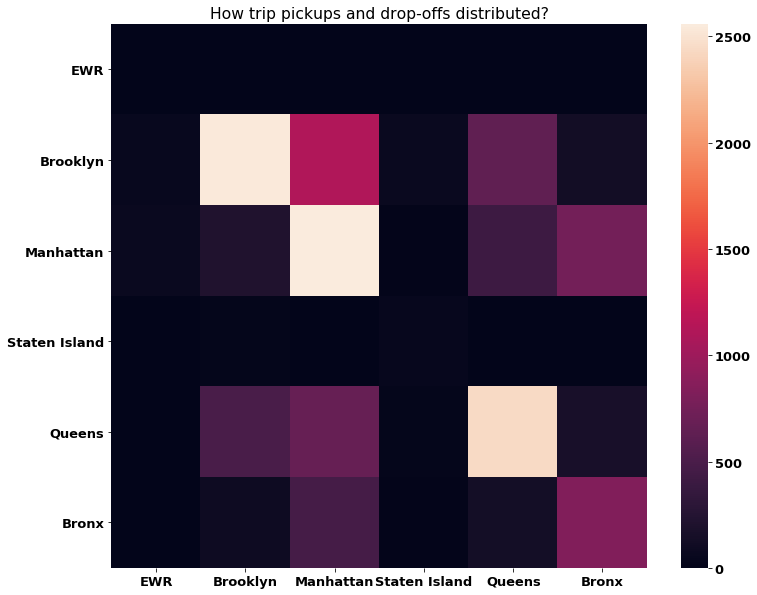

In [250]:
import seaborn as sns

plt.figure(figsize=(12,10))
ax = sns.heatmap(np.sqrt(heat_map), linewidth=0.0, cbar=True, xticklabels=Boroughes, yticklabels=Boroughes)
ax.set_title('How trip pickups and drop-offs distributed?')
plt.show()

### Plot relationship between tip amount and other factors

In [300]:
tmp = cleaned_data.sample(fraction=0.01).select('trip_distance', 'fare_amount', 'tip_amount', 'tolls_amount', 'trip_duration', 'trip_speed', 'all_tax', 'passenger_count', 'payment_type').toPandas()

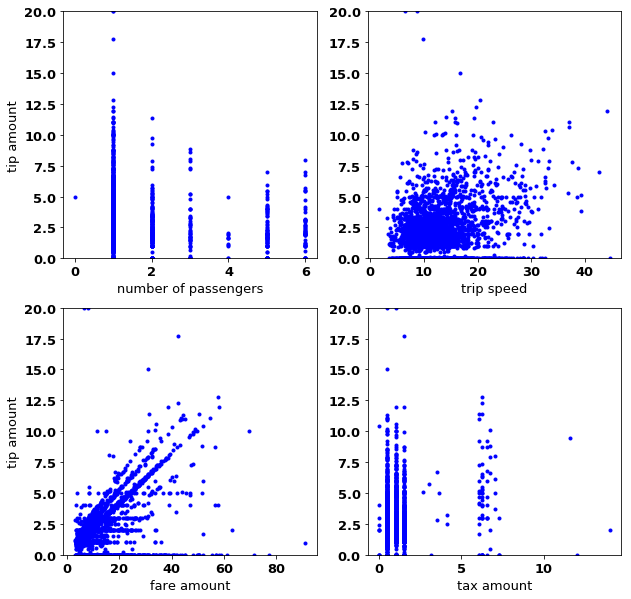

In [347]:
tmp1 = tmp[tmp['payment_type'] == 1].sample(3000)
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(tmp1['passenger_count'], tmp1['tip_amount'], 'b.')
plt.ylim(0, 20)
plt.xlabel('number of passengers')
plt.ylabel('tip amount')

plt.subplot(2, 2, 2)
plt.plot(tmp1['trip_speed'], tmp1['tip_amount'], 'b.')
plt.ylim(0, 20)
plt.xlabel('trip speed')

plt.subplot(2, 2, 3)
plt.plot(tmp1['fare_amount'], tmp1['tip_amount'], 'b.')
plt.ylabel('tip amount')
plt.ylim(0, 20)
plt.xlabel('fare amount')

plt.subplot(2, 2, 4)
plt.plot(tmp1['all_tax'], tmp1['tip_amount'], 'b.')
plt.ylim(0, 20)
plt.xlabel('tax amount')

plt.show()

### Visualize in geography spatial level

In [14]:
import utils
import shapefile

sf = shapefile.Reader("data/taxi_zones/taxi_zones.shp")
fields_name = [field[0] for field in sf.fields[1:]]
shp_dic = dict(zip(fields_name, list(range(len(fields_name)))))

In [18]:
tmp = spark.sql("SELECT PULocationID, count(*) as num_trips, AVG(trip_speed) as avg_speed, AVG(tip_amount) as avg_tip, AVG(payment_type) as payment, AVG(all_tax) as all_tax \
            FROM green_taxi_table \
            WHERE payment_type == 1 OR payment_type == 2 \
            GROUP BY PULocationID").toPandas()

In [25]:
heat_pickups = {}
for idx, row in tmp.iterrows():
    heat_pickups[row['PULocationID']] = row['num_trips']
    
heat_speed = {}
for idx, row in tmp.iterrows():
    heat_speed[row['PULocationID']] = row['avg_speed']
    
heat_tip = {}
for idx, row in tmp.iterrows():
    heat_tip[row['PULocationID']] = row['avg_tip']
    
heat_tax = {}
for idx, row in tmp.iterrows():
    heat_tax[row['PULocationID']] = row['all_tax']

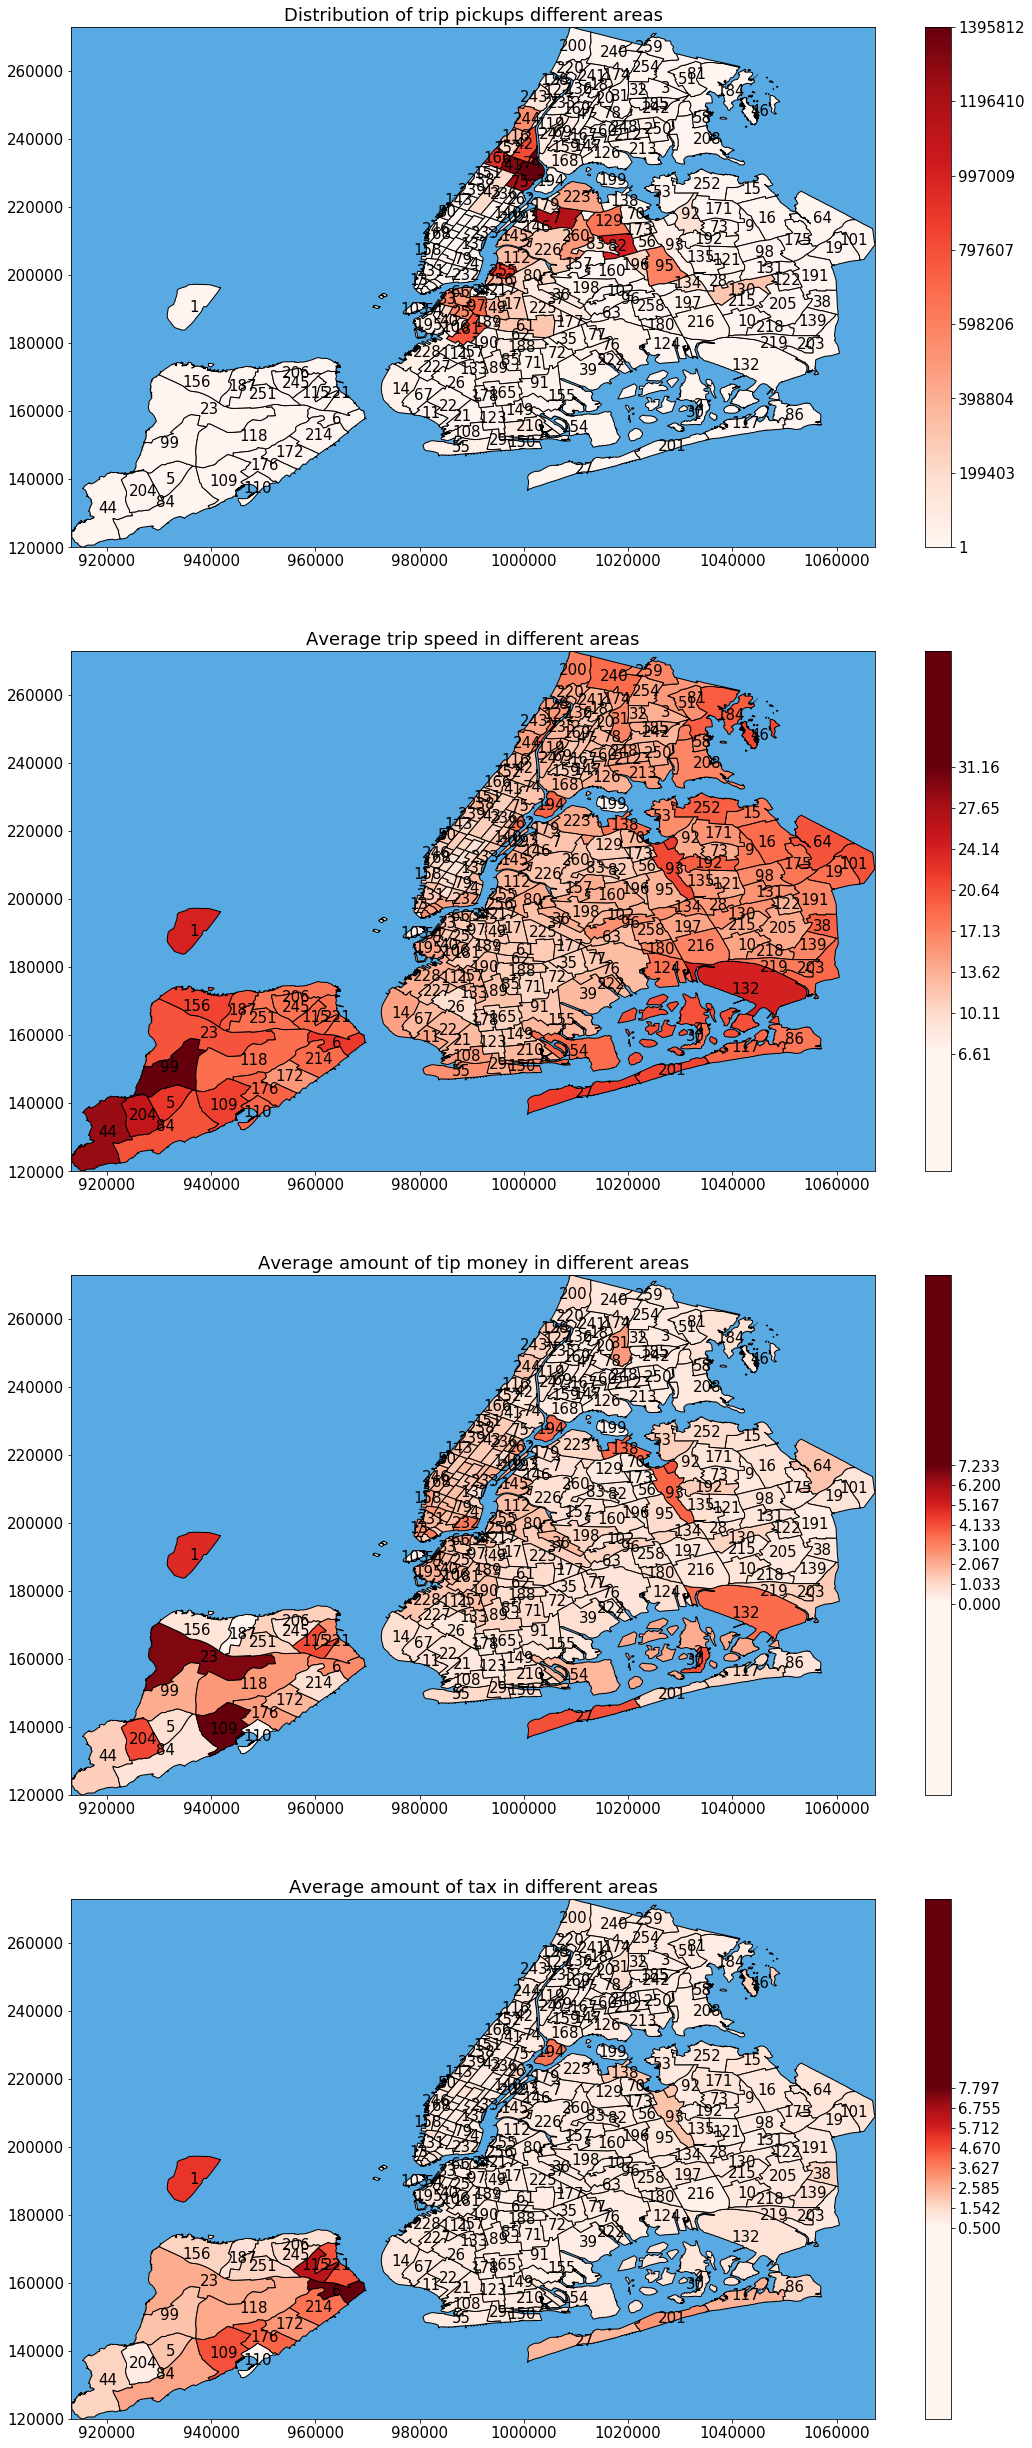

In [32]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,44))
# ax = plt.subplot(1, 2, 1)
# ax.set_title("Boroughs in NYC")
# draw_region_map(ax, sf, heat={'Staten Island':10, 'Queens':2, 'Bronx':3, 'Manhattan':4, 'EWR':5, 'Brooklyn':6})
ax = plt.subplot(4, 1, 1)
ax.set_title("Distribution of trip pickups different areas")
utils.draw_zone_map(ax, sf, heat=heat_pickups)

ax = plt.subplot(4, 1, 2)
ax.set_title("Average trip speed in different areas")
utils.draw_zone_map(ax, sf, heat=heat_speed)

ax = plt.subplot(4, 1, 3)
ax.set_title("Average amount of tip money in different areas")
utils.draw_zone_map(ax, sf, heat=heat_tip)

ax = plt.subplot(4, 1, 4)
ax.set_title("Average amount of tax in different areas")
utils.draw_zone_map(ax, sf, heat=heat_tax)